<a href="https://colab.research.google.com/github/Mach-web/Machine_learning/blob/master/decision_forests/tf_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary modules

In [ ]:
!pip install tensorflow_decision_forests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: keras
    Found existing in

In [ ]:
pip install wurlitzer

In [ ]:
import tensorflow_decision_forests as tfdf

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import math
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
# print decision_forests version
tfdf.__version__

'1.9.0'

#### Train a random forest model using penguins dataset

In [ ]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

In [ ]:
penguins = pd.read_csv("/tmp/penguins.csv")
penguins.tail(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009
343,Chinstrap,Dream,50.2,18.7,198.0,3775.0,female,2009


#### Some data preprocessing

In [ ]:
# view unique counts in species column
penguins['species'].value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

In [ ]:
classes = penguins['species'].unique().tolist()
print('The label names are: ', classes)
print('There indices are: ', classes.index)

The label names are:  ['Adelie', 'Gentoo', 'Chinstrap']
There indices are:  <built-in method index of list object at 0x7a1343696fc0>


In [ ]:
# map the indices to species
penguins['species'] = penguins['species'].map(classes.index)
penguins.tail(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
339,2,Dream,55.8,19.8,207.0,4000.0,male,2009
340,2,Dream,43.5,18.1,202.0,3400.0,female,2009
341,2,Dream,49.6,18.2,193.0,3775.0,male,2009
342,2,Dream,50.8,19.0,210.0,4100.0,male,2009
343,2,Dream,50.2,18.7,198.0,3775.0,female,2009


In [ ]:
penguins['island'].nunique()

3

In [ ]:
penguins['island'].value_counts()

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

#### Split dataset

In [ ]:
np.random.permutation(5)

array([2, 1, 3, 0, 4])

In [ ]:
# randomize penguins dataset
random_penguins = penguins.reindex(np.random.permutation(len(penguins)))
random_penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
169,1,Biscoe,49.2,15.2,221.0,6300.0,male,2007
156,1,Biscoe,47.6,14.5,215.0,5400.0,male,2007
78,0,Torgersen,36.2,16.1,187.0,3550.0,female,2008
204,1,Biscoe,45.1,14.4,210.0,4400.0,female,2008
170,1,Biscoe,46.2,14.5,209.0,4800.0,female,2007


In [ ]:
def split_dataset(dataset, test_ratio = .3):
    split_size = int(test_ratio * len(dataset))
    return dataset[split_size:], dataset[:split_size]
train_penguins_pd, test_penguins_pd = split_dataset(random_penguins)
print("{} examples in train set, {} examples in test set".format(len(train_penguins_pd), len(test_penguins_pd)))

241 examples in train set, 103 examples in test set


#### convert pandas dataframe to tensorflow datasets

In [ ]:
label = "species"
train_penguins = tfdf.keras.pd_dataframe_to_tf_dataset(train_penguins_pd, label = label)
test_penguins = tfdf.keras.pd_dataframe_to_tf_dataset(test_penguins_pd, label = label)
train_penguins

<_PrefetchDataset element_spec=({'island': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'bill_length_mm': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'bill_depth_mm': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'flipper_length_mm': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'body_mass_g': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'sex': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'year': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### Train the random forest model

In [ ]:
# define the model
model_1 = tfdf.keras.RandomForestModel(verbose = 0,
        compute_oob_variable_importances = True)
model_1.fit(train_penguins)

#### Remarks
No input features are specified. Therefore, all the columns will be used as input features except for the label.

The feature used by the model are shown in the training logs and in the model.summary().

DFs consume natively numerical, categorical, categorical-set features and missing-values. Numerical features do not need to be normalized.

Categorical string values do not need to be encoded in a dictionary.

No training hyper-parameters are specified. Therefore the default hyper-parameters will be used. Default hyper-parameters provide reasonable results in most situations.

Calling compile on the model before the fit is optional. Compile can be used to provide extra evaluation metrics.

Training algorithms do not need validation datasets. If a validation dataset is provided, it will only be used to show metrics.

Tweak the verbose argument to RandomForestModel to control the amount of displayed training logs. Set verbose=0 to hide most of the logs. Set verbose=2 to show all the logs.

Reference: https://www.tensorflow.org/decision_forests/tutorials/beginner_colab

#### Evaluate the model

In [ ]:
model_1.compile(metrics = ["accuracy"])
evaluation = model_1.evaluate(test_penguins, return_dict = True)

for name, value in evaluation.items():
    print("{} : {}".format(name, value))

1/1 [==============================] - 0s 401ms/step - loss: 0.0000e+00 - accuracy: 0.9806
loss : 0.0
accuracy : 0.9805825352668762


#### Save the model to prepare for tensorflow serving

In [ ]:
model_1.save("/tmp/penguins_saved_model")

#### Plot model

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx = 0, max_depth = 3)

#### Model summary

In [ ]:
model_1.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	bill_depth_mm
	bill_length_mm
	body_mass_g
	flipper_length_mm
	island
	sex
	year

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.    "bill_length_mm"  0.482572 ################
    2. "flipper_length_mm"  0.398520 ##########
    3.     "bill_depth_mm"  0.343565 ######
    4.            "island"  0.331701 #####
    5.       "body_mass_g"  0.276767 #
    6.               "sex"  0.252305 
    7.              "year"  0.251104 

Variable Importance: MEAN_DECREASE_IN_ACCURACY:
    1.    "bill_length_mm"  0.157676 ################
    2.            "island"  0.029046 ##
    3.     

#### Use make_inspector to make summary programmatically

In [ ]:
model_1.make_inspector().features()

["bill_depth_mm" (1; #1),
 "bill_length_mm" (1; #2),
 "body_mass_g" (1; #3),
 "flipper_length_mm" (1; #4),
 "island" (4; #5),
 "sex" (4; #6),
 "year" (1; #7)]

In [ ]:
model_1.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("bill_length_mm" (1; #2), 121.0),
  ("flipper_length_mm" (1; #4), 115.0),
  ("bill_depth_mm" (1; #1), 58.0),
  ("body_mass_g" (1; #3), 4.0),
  ("island" (4; #5), 2.0)],
 'INV_MEAN_MIN_DEPTH': [("bill_length_mm" (1; #2), 0.4825719063186105),
  ("flipper_length_mm" (1; #4), 0.39851978366068885),
  ("bill_depth_mm" (1; #1), 0.3435646409683399),
  ("island" (4; #5), 0.33170070321665923),
  ("body_mass_g" (1; #3), 0.2767670809320066),
  ("sex" (4; #6), 0.2523051975416811),
  ("year" (1; #7), 0.2511036209468252)],
 'MEAN_DECREASE_IN_AUC_1_VS_OTHERS': [("bill_length_mm" (1; #2),
   0.06398334489937574),
  ("flipper_length_mm" (1; #4), 0.004510756419154327),
  ("island" (4; #5), 0.003747397640528227),
  ("bill_depth_mm" (1; #1), 0.003192227619709276),
  ("body_mass_g" (1; #3), 0.00020818875780725943),
  ("sex" (4; #6), 6.93962526023828e-05),
  ("year" (1; #7), 0.0)],
 'MEAN_DECREASE_IN_PRAUC_3_VS_OTHERS': [("bill_length_mm" (1; #2),
   0.48532337407547343),
  ("island" (4; #5

#### Check model self evaluation on train dataset

In [ ]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=241, accuracy=0.983402489626556, loss=0.07048633929604811, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

### Plot the training logs

In [ ]:
model_1.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=86, accuracy=0.9418604651162791, loss=2.095561138419218, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=240, accuracy=0.9666666666666667, loss=0.5067747053379814, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=241, accuracy=0.983402489626556, loss=0.07085552941466763, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=241, accuracy=0.9875518672199171, loss=0.06708402925507162, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=241, accuracy=0.991701244813278, loss=0.06388380350660981, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=241, accuracy=0.9875518672199171, loss=0.06667542238082134, rmse=Non

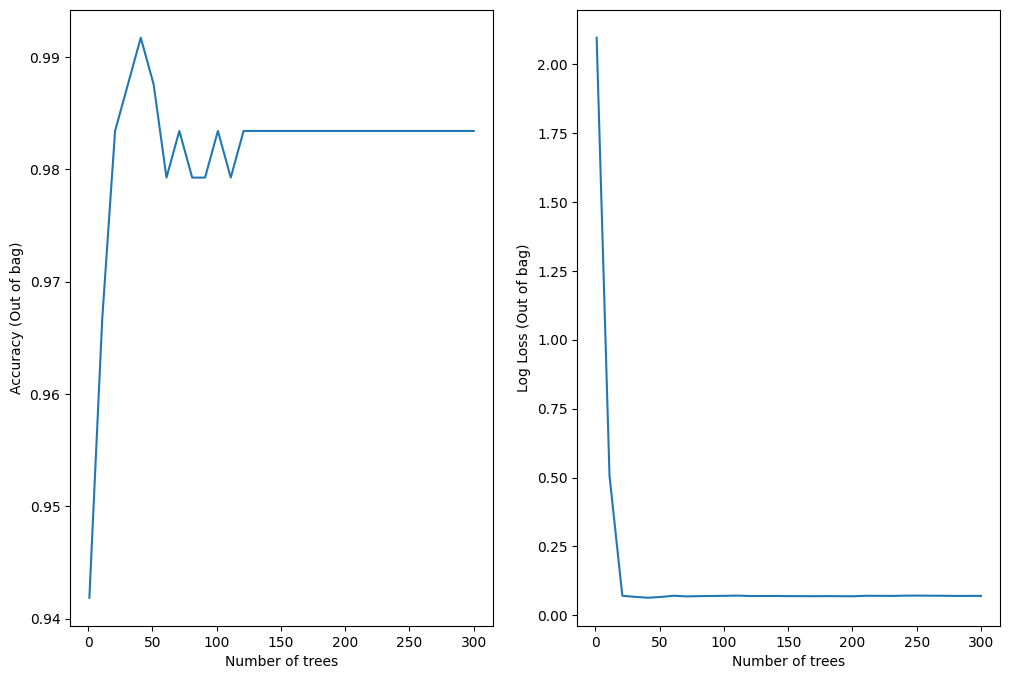

In [ ]:
# let's now plots
logs = model_1.make_inspector().training_logs()

plt.figure(figsize = (12,8))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (Out of bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (Out of bag)")

plt.show()

#### Use tensorboard to make visualisations

In [ ]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# clear existing results if any
!rm -rf "/tmp/tensorboard_logs"

In [ ]:
# export metadata to tensorboard
model_1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

In [ ]:
#start a tensorboard instance
# %tensorboard --logdir "/tmp/tensorboard_logs"

### Train with a different algorithm

In [ ]:
# view all models
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]